In [2]:
import numpy as np
import pickle as pickle
import pandas as pd
import math
import seaborn as sns

import matplotlib.pyplot as plt

import pyeeg as pe
import pywt

from sklearn import svm
from sklearn.preprocessing import normalize

import os
import time

In [3]:
import tensorflow as tf
import keras

from tensorflow.keras.utils import to_categorical 

from keras.models import Sequential
from keras.models import load_model

from keras.layers import Conv1D, MaxPooling1D
from keras.layers import BatchNormalization, Activation, Dropout, Flatten, Dense

from keras.layers import Bidirectional, TimeDistributed
from keras.layers import LSTM, GRU, SimpleRNN

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.regularizers import l2

from sklearn.metrics import confusion_matrix, classification_report

# Datasets Preparation

## Data Preprocessing

### Epoching + Label Mapping

In [4]:
def label_mapping(valence, arousal):
    # HVHA, HVLA, LVHA, and LVLA
    
    if (valence > 5 and arousal > 5):
        label = 0 #'HVHA'
    elif (valence > 5 and arousal <= 5):
        label = 1 #'HVLA'
    elif (valence <= 5 and arousal > 5):
        label = 2 #'LVHA'
    elif (valence <= 5 and arousal <= 5):
        label = 3 #'LVLA'
    
    return label

In [5]:
def map_label(label):
    new_label = label_mapping(label[0], label[1]) 
    return new_label

In [6]:
chan = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
       21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
print(chan)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]


In [7]:
channel = [1,2,3,4,7,11,13,17,19,20,21,25,29,31]
channel_test = [0, 16] # Fp1, Fp2

window_size = 256 #Averaging band power of 2 sec
step_size = 256 #Each 1 sec update once
subject_list = [
    '01','02','03','04','05','06','07','08','09','10'
    ,'11','12','13','14','15','16','17','18','19','20'
    ,'21','22','23','24','25','26','27','28','29','30'
    ,'31','32'
]

subject_train = [
    '01','02','03','04','05','06','07','08','09','10'
    ,'11','12','13','14','15','16','17','18','19','20'
    ,'21','22','23','24','25'
]

subject_val = ['26','27','28','29','30']
subject_test = ['31','32']

In [55]:
def epoching (sub, channel, window_size, step_size):
    
    signal = []
    with open(r"D:\Downloads\EE798R_IRP_ResearchPaper1\PREPROCESSED\PREPROCESSED\data_preprocessed_python\s" + sub + '.dat', 'rb') as file:

        subject = pickle.load(file, encoding='latin1') #resolve the python 2 data problem by encoding : latin1

        for i in range (0,40):
            # loop over 0-39 trials
            data = subject["data"][i]
            labels = subject["labels"][i]
            labels = np.array(map_label(labels))
            start = 0

            while start + window_size <= data.shape[1]:
                array = []
                for j in channel:
                    X = data[j][start : start + window_size] #Slice raw data over 2 sec, at interval of 1 sec
                    array.append(np.array(X))
                    array.append(np.array(labels))
                    signal.append(np.array(array))
  
                start = start + step_size
                
        signal = np.array(signal)
        np.save('D:\\Downloads\\EE798R_IRP_ResearchPaper1\\PREPROCESSED\\PREPROCESSED\\data_preprocessed_python\\s' + sub, signal, allow_pickle=True, fix_imports=True)

In [56]:
import numpy as np
import pickle

def map_label(label):
    # Define your mapping function for labels if needed
    return label

def epoching(sub, channel, window_size, step_size):
    signal = []
    file_path = f"D:\\Downloads\\EE798R_IRP_ResearchPaper1\\PREPROCESSED\\PREPROCESSED\\data_preprocessed_python\\s{sub}.dat"

    with open(file_path, 'rb') as file:
        subject = pickle.load(file, encoding='latin1')  # Resolve Python 2 data issue with encoding

        for i in range(40):  # Loop over 0-39 trials
            data = subject["data"][i]
            labels = subject["labels"][i]
            labels = np.array(map_label(labels)).flatten()  # Flatten labels to 1D

            start = 0
            while start + window_size <= data.shape[1]:
                for j in channel:
                    X = data[j][start : start + window_size]  # Slice raw data over 2 sec interval
                    entry = np.concatenate([X.flatten(), labels])  # Concatenate 1D X and labels
                    signal.append(entry)
                
                start += step_size  # Move the window by step size
                
    signal = np.array(signal)  # Convert list to numpy array
    output_path = f'D:\\Downloads\\EE798R_IRP_ResearchPaper1\\PREPROCESSED\\PREPROCESSED\\data_preprocessed_python\\s{sub}.npy'
    np.save(output_path, signal, allow_pickle=True, fix_imports=True)


In [57]:
import numpy as np
import pickle

def epoching(sub, channel, window_size, step_size):
    signal = []

    # Open and load the .dat file
    with open(r"D:\Downloads\EE798R_IRP_ResearchPaper1\PREPROCESSED\PREPROCESSED\data_preprocessed_python\s" + sub + '.dat', 'rb') as file:
        subject = pickle.load(file, encoding='latin1')  # Resolve the python2 data problem with encoding: latin1

        # Loop through 0-39 trials
        for i in range(40):  # Assuming 40 trials per subject
            data = subject["data"][i]
            labels = subject["labels"][i]
            labels = np.array(map_label(labels))  # Apply your label mapping function

            start = 0

            # Sliding window for epoching
            while start + window_size <= data.shape[1]:
                # Create a temporary list to store features and labels for this window
                epoch_data = []
                
                for j in channel:
                    # Slice the data for each channel (data[j] is a channel)
                    X = data[j][start:start + window_size]
                    epoch_data.append(X)
                
                # Ensure the labels are the same shape as the epoch data
                # Here, we append both the feature (epoch_data) and the corresponding labels
                epoch_data = np.array(epoch_data)  # Convert to numpy array for consistency
                signal.append((epoch_data, labels))  # Store both feature and label together
                
                start += step_size  # Move the window

    # Convert the signal list to a numpy array
    signal = np.array(signal, dtype=object)  # Use dtype=object for mixed data types (features + labels)
    
    # Save the processed signal to a .npy file
    np.save(r'D:\Downloads\EE798R_IRP_ResearchPaper1\PREPROCESSED\PREPROCESSED\data_preprocessed_python\s' + sub, signal, allow_pickle=True, fix_imports=True)
    #print(f"Epoching completed for subject {sub} and saved.")

# Usage
#subject_list = ['01', '02', '03']  # Example list of subjects
#window_size = 100  # Example window size
#step_size = 50  # Example step size
#channel = [0, 1, 2]  # Example channel list (e.g., 0, 1, 2 are EEG channels)

# Process each subject
for sub in subject_list:
    epoching(sub, channel, window_size, step_size)
    print(f"Processed subject {sub}")


Processed subject 01


KeyboardInterrupt: 

In [8]:
import numpy as np
import pickle

def map_label(label):
    # Define your mapping function for labels if needed
    return label

def epoching(sub, channel, window_size, step_size):
    signal = []
    file_path = f"D:\\Downloads\\EE798R_IRP_ResearchPaper1\\PREPROCESSED\\PREPROCESSED\\data_preprocessed_python\\s{sub}.dat"

    with open(file_path, 'rb') as file:
        subject = pickle.load(file, encoding='latin1')  # Resolve Python 2 data issue with encoding

        for i in range(40):  # Loop over 0-39 trials
            data = subject["data"][i]
            labels = subject["labels"][i]
            label = map_label(labels)[0]  # Assuming a single label per trial

            start = 0
            while start + window_size <= data.shape[1]:
                for j in channel:
                    X = data[j][start : start + window_size]  # Slice raw data over 2 sec interval
                    entry = (np.array(X), label)  # Store data segment and label as a tuple
                    signal.append(entry)
                
                start += step_size  # Move the window by step size
                
    signal = np.array(signal, dtype=object)  # Convert list to numpy array of objects
    output_path = f'D:\\Downloads\\EE798R_IRP_ResearchPaper1\\PREPROCESSED\\PREPROCESSED\\data_preprocessed_python\\s{sub}.npy'
    np.save(output_path, signal, allow_pickle=True, fix_imports=True)



In [9]:
for subjects in subject_list:
    epoching (subjects, channel, window_size, step_size)
    print(subjects)

01
02
03
04
05
06
07
08
09
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32


In [10]:
with open('D:\\Downloads\\EE798R_IRP_ResearchPaper1\\PREPROCESSED\\PREPROCESSED\\data_preprocessed_python\\s01' + '.npy', 'rb') as file:
    sub = np.load(file,allow_pickle=True)

In [11]:
print(sub.shape)
print(sub[0].shape)
print(sub[0][0].shape)
print(sub[0][1].shape)

(17360, 2)
(2,)
(256,)
()


# Data Preparation

## Combine Data

In [12]:
data = []
label = []

for subjects in subject_list:

    with open('D:\\Downloads\\EE798R_IRP_ResearchPaper1\\PREPROCESSED\\PREPROCESSED\\data_preprocessed_python\\s' + subjects + '.npy', 'rb') as file:
        sub = np.load(file,allow_pickle=True)
        for i in range (0,sub.shape[0]):
            data.append(sub[i][0])
            label.append(sub[i][1])

np.save('D:\\Downloads\\EE798R_IRP_ResearchPaper1\\PREPROCESSED\\PREPROCESSED\\data_preprocessed_python\\data', np.array(data), allow_pickle=True, fix_imports=True)
np.save('D:\\Downloads\\EE798R_IRP_ResearchPaper1\\PREPROCESSED\\PREPROCESSED\\data_preprocessed_python\\label', np.array(label), allow_pickle=True, fix_imports=True)
print("Training datasets:", np.array(data).shape, np.array(label).shape)

Training datasets: (555520, 256) (555520,)


In [13]:
unique, counts = np.unique(label, return_counts=True)
label_dist = dict(zip(unique, counts))
print(label_dist)

{1.0: 19964, 1.01: 1302, 1.03: 434, 1.04: 868, 1.08: 434, 1.1: 434, 1.15: 434, 1.21: 868, 1.22: 434, 1.23: 434, 1.35: 434, 1.36: 434, 1.38: 434, 1.4: 434, 1.45: 434, 1.47: 434, 1.62: 434, 1.67: 434, 1.74: 434, 1.77: 434, 1.79: 434, 1.82: 434, 1.83: 434, 1.85: 434, 1.86: 1736, 1.88: 868, 1.9: 434, 1.91: 1302, 1.92: 1736, 1.94: 868, 1.95: 1302, 1.96: 2604, 1.97: 1736, 1.99: 3472, 2.0: 1302, 2.01: 2604, 2.03: 1302, 2.04: 434, 2.05: 868, 2.06: 868, 2.08: 868, 2.09: 868, 2.12: 434, 2.13: 434, 2.14: 434, 2.17: 1736, 2.19: 868, 2.26: 434, 2.28: 1736, 2.31: 434, 2.32: 434, 2.33: 434, 2.36: 434, 2.41: 434, 2.44: 434, 2.46: 434, 2.47: 434, 2.5: 434, 2.51: 1302, 2.53: 434, 2.54: 434, 2.59: 434, 2.64: 434, 2.67: 434, 2.68: 434, 2.71: 868, 2.72: 434, 2.78: 868, 2.79: 434, 2.81: 434, 2.82: 1302, 2.85: 1736, 2.86: 868, 2.87: 434, 2.88: 434, 2.9: 868, 2.92: 2604, 2.94: 1302, 2.95: 868, 2.96: 1302, 2.97: 3038, 2.99: 5208, 3.0: 2604, 3.01: 3038, 3.03: 3038, 3.04: 3038, 3.05: 3472, 3.06: 434, 3.08: 1736,

In [14]:
with open('D:\\Downloads\\EE798R_IRP_ResearchPaper1\\PREPROCESSED\\PREPROCESSED\\data_preprocessed_python\\data.npy', 'rb') as fileTrain:
    data  = np.load(fileTrain)
    
with open('D:\\Downloads\\EE798R_IRP_ResearchPaper1\\PREPROCESSED\\PREPROCESSED\\data_preprocessed_python\\label.npy', 'rb') as fileTrainL:
    label  = np.load(fileTrainL)

## Train Val Test Split

In [15]:
print(data.shape)
print(label.shape)

(555520, 256)
(555520,)


In [16]:
x_train, x, y_train, y = train_test_split(data, label, test_size=0.4, random_state=42)

In [17]:
x_val, x_test, y_val, y_test = train_test_split(x, y, test_size=0.5, random_state=42)

In [18]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

(333312, 256)
(333312,)
(111104, 256)
(111104,)
(111104, 256)
(111104,)


In [19]:
unique, counts = np.unique(y_train, return_counts=True)
label_dist = dict(zip(unique, counts))
print(label_dist)
unique, counts = np.unique(y_val, return_counts=True)
label_dist = dict(zip(unique, counts))
print(label_dist)
unique, counts = np.unique(y_test, return_counts=True)
label_dist = dict(zip(unique, counts))
print(label_dist)

{1.0: 12001, 1.01: 806, 1.03: 281, 1.04: 525, 1.08: 274, 1.1: 261, 1.15: 269, 1.21: 543, 1.22: 269, 1.23: 266, 1.35: 273, 1.36: 255, 1.38: 250, 1.4: 239, 1.45: 242, 1.47: 249, 1.62: 259, 1.67: 275, 1.74: 273, 1.77: 260, 1.79: 263, 1.82: 267, 1.83: 284, 1.85: 258, 1.86: 1058, 1.88: 544, 1.9: 262, 1.91: 767, 1.92: 1077, 1.94: 507, 1.95: 797, 1.96: 1530, 1.97: 1023, 1.99: 2077, 2.0: 794, 2.01: 1577, 2.03: 808, 2.04: 266, 2.05: 522, 2.06: 518, 2.08: 518, 2.09: 535, 2.12: 254, 2.13: 261, 2.14: 269, 2.17: 1031, 2.19: 524, 2.26: 282, 2.28: 1044, 2.31: 279, 2.32: 266, 2.33: 258, 2.36: 251, 2.41: 267, 2.44: 251, 2.46: 263, 2.47: 279, 2.5: 269, 2.51: 800, 2.53: 261, 2.54: 266, 2.59: 271, 2.64: 259, 2.67: 267, 2.68: 265, 2.71: 506, 2.72: 242, 2.78: 529, 2.79: 253, 2.81: 271, 2.82: 783, 2.85: 1044, 2.86: 506, 2.87: 261, 2.88: 271, 2.9: 512, 2.92: 1564, 2.94: 792, 2.95: 532, 2.96: 741, 2.97: 1841, 2.99: 3181, 3.0: 1578, 3.01: 1830, 3.03: 1809, 3.04: 1797, 3.05: 2106, 3.06: 272, 3.08: 1017, 3.09: 52

In [20]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

# Save and Load Datasets

In [21]:
np.save('D:\\Downloads\\EE798R_IRP_ResearchPaper1\\PREPROCESSED\\PREPROCESSED\\data_preprocessed_python\\x_train', np.array(x_train), allow_pickle=True, fix_imports=True)
np.save('D:\\Downloads\\EE798R_IRP_ResearchPaper1\\PREPROCESSED\\PREPROCESSED\\data_preprocessed_python\\y_train', np.array(y_train), allow_pickle=True, fix_imports=True)
np.save('D:\\Downloads\\EE798R_IRP_ResearchPaper1\\PREPROCESSED\\PREPROCESSED\\data_preprocessed_python\\x_val', np.array(x_val), allow_pickle=True, fix_imports=True)
np.save('D:\\Downloads\\EE798R_IRP_ResearchPaper1\\PREPROCESSED\\PREPROCESSED\\data_preprocessed_python\\y_val', np.array(y_val), allow_pickle=True, fix_imports=True)
np.save('D:\\Downloads\\EE798R_IRP_ResearchPaper1\\PREPROCESSED\\PREPROCESSED\\data_preprocessed_python\\x_test', np.array(x_test), allow_pickle=True, fix_imports=True)
np.save('D:\\Downloads\\EE798R_IRP_ResearchPaper1\\PREPROCESSED\\PREPROCESSED\\data_preprocessed_python\\y_test', np.array(y_test), allow_pickle=True, fix_imports=True)

In [22]:
with open('D:\\Downloads\\EE798R_IRP_ResearchPaper1\\PREPROCESSED\\PREPROCESSED\\data_preprocessed_python\\x_train.npy', 'rb') as file:
    x_train = np.load(file, allow_pickle=True)
with open('D:\\Downloads\\EE798R_IRP_ResearchPaper1\\PREPROCESSED\\PREPROCESSED\\data_preprocessed_python\\y_train.npy', 'rb') as file:
    y_train = np.load(file, allow_pickle=True)
with open('D:\\Downloads\\EE798R_IRP_ResearchPaper1\\PREPROCESSED\\PREPROCESSED\\data_preprocessed_python\\x_val.npy', 'rb') as file:
    x_val = np.load(file, allow_pickle=True)
with open('D:\\Downloads\\EE798R_IRP_ResearchPaper1\\PREPROCESSED\\PREPROCESSED\\data_preprocessed_python\\y_val.npy', 'rb') as file:
    y_val = np.load(file, allow_pickle=True)
with open('D:\\Downloads\\EE798R_IRP_ResearchPaper1\\PREPROCESSED\\PREPROCESSED\\data_preprocessed_python\\x_test.npy', 'rb') as file:
    x_test = np.load(file, allow_pickle=True)
with open('D:\\Downloads\\EE798R_IRP_ResearchPaper1\\PREPROCESSED\\PREPROCESSED\\data_preprocessed_python\\y_test.npy', 'rb') as file:
    y_test = np.load(file, allow_pickle=True)

# Scaling and Normalization

In [23]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

(333312, 256)
(333312, 10)
(111104, 256)
(111104, 10)
(111104, 256)
(111104, 10)


In [24]:
scaler = StandardScaler()

In [25]:
# 4 Normalization -> Standardization 
x_train = scaler.fit_transform(normalize(x_train))
x_val = scaler.fit_transform(normalize(x_val))
x_test = scaler.fit_transform(normalize(x_test))

## Sample

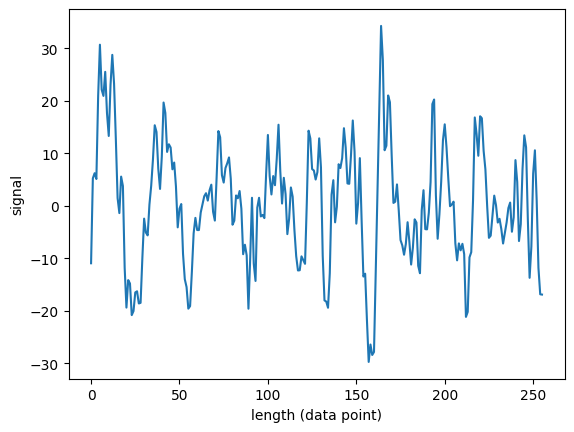

In [26]:
with open('D:\\Downloads\\EE798R_IRP_ResearchPaper1\\PREPROCESSED\\PREPROCESSED\\data_preprocessed_python\\x_train.npy', 'rb') as file:
    sample = np.load(file, allow_pickle=True)

plt.plot(sample[0])
# plt.title("Epoched Data Sample")
plt.ylabel('signal')
plt.xlabel('length (data point)')
plt.show()

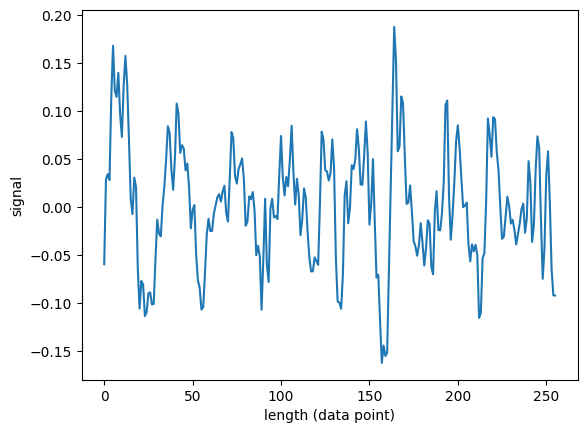

In [28]:
with open('D:\\Downloads\\EE798R_IRP_ResearchPaper1\\PREPROCESSED\\PREPROCESSED\\data_preprocessed_python\\x_train.npy', 'rb') as file:
    sample = np.load(file, allow_pickle=True)

sample = normalize(sample)
    
plt.plot(sample[0])
# plt.title("Data Sample After Z-Score Standardization")
plt.ylabel('signal')
plt.xlabel('length (data point)')
plt.show()

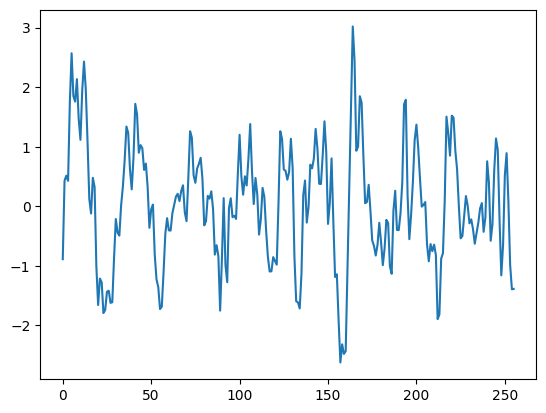

In [29]:
with open('D:\\Downloads\\EE798R_IRP_ResearchPaper1\\PREPROCESSED\\PREPROCESSED\\data_preprocessed_python\\x_train.npy', 'rb') as file:
    sample = np.load(file, allow_pickle=True)

sample = scaler.fit_transform(normalize(sample))
    
plt.plot(sample[0])
plt.show()

## Reshaping

In [30]:
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1], 1)
x_val = x_val.reshape(x_val.shape[0],x_test.shape[1],1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],1)

In [31]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(333312, 256, 1)
(111104, 256, 1)
(111104, 256, 1)
(333312, 10)
(111104, 10)
(111104, 10)


# Train Data

In [32]:
input_shape=(x_train.shape[1],x_train.shape[2])
print(input_shape)

(256, 1)


In [34]:
batch_size = 256
num_classes = 10
epochs = 20

## Model 1: SimpleRNN

In [ ]:
## removed

## Model 2: GRU

In [35]:
model_2 = Sequential()

model_2.add(Conv1D(128, 3, activation='relu', input_shape=input_shape))
model_2.add(MaxPooling1D(pool_size=2))
model_2.add(Dropout(0.2))

model_2.add(Conv1D(128, 3,  activation='relu'))
model_2.add(MaxPooling1D(pool_size=2))
model_2.add(Dropout(0.2))

model_2.add(GRU(units = 256, return_sequences=True))  
model_2.add(Dropout(0.2))

model_2.add(GRU(units = 32))
model_2.add(Dropout(0.2))

model_2.add(Flatten())

model_2.add(Dense(units = 128, activation='relu'))
model_2.add(Dropout(0.2))

model_2.add(Dense(units = num_classes))
model_2.add(Activation('softmax'))

model_2.summary()

c:\Users\ABHISHEK PRAKASH\.conda\envs\J\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 254, 128)       │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 127, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 127, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 125, 128)       │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 62, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 62, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 62, 256)        │       296,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 62, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │        27,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 379,594 (1.45 MB)

 Trainable params: 379,594 (1.45 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
model_2.compile(
    optimizer ="adam",
    loss = 'categorical_crossentropy',
    metrics=["accuracy"]
)

In [37]:
history_2 = model_2.fit(
    x_train, 
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    verbose=1,
    validation_data=(x_val, y_val),
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=20,
            restore_best_weights=True
        )
    ]
)

Epoch 1/20
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 725s 550ms/step - accuracy: 0.1737 - loss: 2.1287 - val_accuracy: 0.1814 - val_loss: 2.1089
Epoch 2/20
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 679s 522ms/step - accuracy: 0.1830 - loss: 2.1068 - val_accuracy: 0.1851 - val_loss: 2.0996
Epoch 3/20
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 672s 516ms/step - accuracy: 0.1839 - loss: 2.1012 - val_accuracy: 0.1861 - val_loss: 2.0975
Epoch 4/20
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 659s 506ms/step - accuracy: 0.1831 - loss: 2.0999 - val_accuracy: 0.1878 - val_loss: 2.0936
Epoch 5/20
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 666s 511ms/step - accuracy: 0.1875 - loss: 2.0955 - val_accuracy: 0.1898 - val_loss: 2.0898
Epoch 6/20
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 660s 507ms/step - accuracy: 0.1889 - loss: 2.0913 - val_accuracy: 0.1891 - val_loss: 2.0857
Epoch 7/20
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 685s 526ms/step - accuracy: 0.1927 - loss: 2.0848 - val_accuracy: 0.1934 - val_loss: 2.0831
Epoch 8/20
1220/1302 ━━━━━━━━━━━━━━━━━━━━ 40s 499ms/step - acc

KeyboardInterrupt: 

In [ ]:
score_2 = model_2.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score_2[0])
print('Test accuracy:', score_2[1])

3472/3472 [==============================] - 21s 5ms/step - loss: 0.0066 - accuracy: 0.9992
Test loss: 0.006638647988438606
Test accuracy: 0.9992169737815857


### Save Model

In [ ]:
model_2.save('C:\\.Farhad\\.Telkom\\Emotion Recognition\\Datasets\\DEAP\\all\\gru_model.h5')
np.save('C:\\.Farhad\\.Telkom\\Emotion Recognition\\Datasets\\DEAP\\all\\gru_model.npy', history_2.history)

## Model 3: LSTM

In [ ]:
factor = 0.01
rate = 0.2

In [ ]:
model_3 = Sequential()

model_3.add(Conv1D(128, 3, activation='relu', input_shape=input_shape))
model_3.add(MaxPooling1D(pool_size=2))
model_3.add(Dropout(rate))

model_3.add(Conv1D(128, 3, activation='relu'))
model_3.add(MaxPooling1D(pool_size=2))
model_3.add(Dropout(rate))

model_3.add(LSTM(units = 256, return_sequences=True))  
model_3.add(Dropout(rate))

model_3.add(LSTM(units = 32))
model_3.add(Dropout(rate))

model_3.add(Flatten())

model_3.add(Dense(units = 128, activation='relu'))
model_3.add(Dropout(rate))

model_3.add(Dense(units = num_classes))
model_3.add(Activation('softmax'))

model_3.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_31 (Conv1D)           (None, 254, 128)          512       
_________________________________________________________________
max_pooling1d_31 (MaxPooling (None, 127, 128)          0         
_________________________________________________________________
dropout_73 (Dropout)         (None, 127, 128)          0         
_________________________________________________________________
conv1d_32 (Conv1D)           (None, 125, 128)          49280     
_________________________________________________________________
max_pooling1d_32 (MaxPooling (None, 62, 128)           0         
_________________________________________________________________
dropout_74 (Dropout)         (None, 62, 128)           0         
_________________________________________________________________
lstm_26 (LSTM)               (None, 62, 256)         

In [ ]:
model_3.compile(
    optimizer ="adam",
    loss = 'categorical_crossentropy',
    metrics=["accuracy"]
)

In [ ]:
history_3 = model_3.fit(
    x_train, 
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    verbose=1,
    validation_data=(x_val, y_val),
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=20,
            restore_best_weights=True
        )
    ]
)

: 

In [ ]:
score_3 = model_3.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score_3[0])
print('Test accuracy:', score_3[1])

3472/3472 [==============================] - 29s 8ms/step - loss: 0.0013 - accuracy: 1.0000
Test loss: 0.001256258343346417
Test accuracy: 0.9999639987945557


### Save Model

In [ ]:
model_3.save('C:\\.Farhad\\.Telkom\\Emotion Recognition\\Datasets\\DEAP\\all\\lstm_model.h5')
np.save('C:\\.Farhad\\.Telkom\\Emotion Recognition\\Datasets\\DEAP\\all\\lstm_model.npy', history_3.history)

# Load Model, Results, and Model Analysis

## GRU Model

In [ ]:
directory = 'C:\\.Farhad\\.Telkom\\Emotion Recognition\\Datasets\\DEAP\\all\\gru_model.h5'
gru_model = load_model(directory)
gru_model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_29 (Conv1D)           (None, 254, 128)          512       
_________________________________________________________________
max_pooling1d_29 (MaxPooling (None, 127, 128)          0         
_________________________________________________________________
dropout_68 (Dropout)         (None, 127, 128)          0         
_________________________________________________________________
conv1d_30 (Conv1D)           (None, 125, 128)          49280     
_________________________________________________________________
max_pooling1d_30 (MaxPooling (None, 62, 128)           0         
_________________________________________________________________
dropout_69 (Dropout)         (None, 62, 128)           0         
_________________________________________________________________
gru (GRU)                    (None, 62, 256)         

In [ ]:
gru_history = np.load('C:\\.Farhad\\.Telkom\\Emotion Recognition\\Datasets\\DEAP\\all\\gru_model.npy',allow_pickle='TRUE').item()
gru_history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
print("Training Accuracy: ", np.max(gru_history['accuracy']))
print("Training Loss: ", np.min(gru_history['loss']))
print("Validation Accuracy: ", np.max(gru_history['val_accuracy']))
print("Validation Loss: ", np.min(gru_history['val_loss']))

Training Accuracy:  0.9634636640548706
Training Loss:  0.10709526389837265
Validation Accuracy:  0.9991719722747803
Validation Loss:  0.0067257145419716835


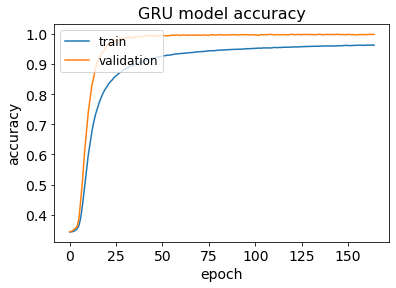

In [ ]:
# summarize history for accuracy
plt.plot(gru_history['accuracy'])
plt.plot(gru_history['val_accuracy'])
plt.title('GRU model accuracy', fontsize=16)
plt.ylabel('accuracy', fontsize=14)
plt.xlabel('epoch', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(['train', 'validation'], loc='upper left', fontsize=12)
plt.show()

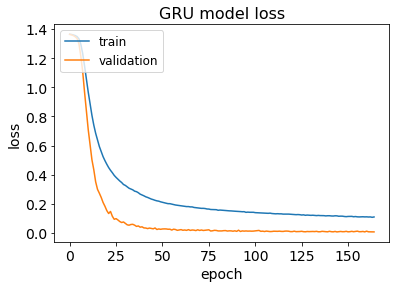

In [ ]:
# summarize history for loss
plt.plot(gru_history['loss'])
plt.plot(gru_history['val_loss'])
plt.title('GRU model loss', fontsize=16)
plt.ylabel('loss', fontsize=14)
plt.xlabel('epoch', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(['train', 'validation'], loc='upper left', fontsize=12)
plt.show()

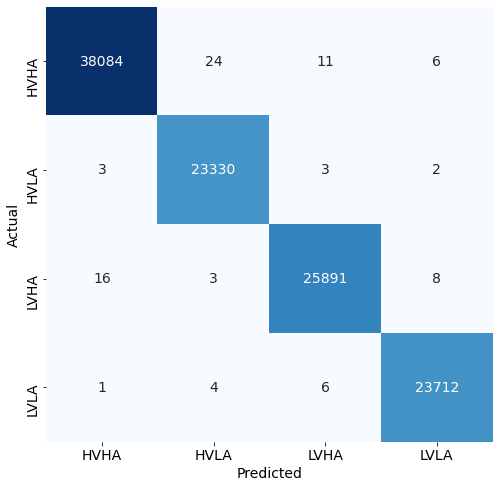

Classification Report:
----------------------
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     38125
           1       1.00      1.00      1.00     23338
           2       1.00      1.00      1.00     25918
           3       1.00      1.00      1.00     23723

    accuracy                           1.00    111104
   macro avg       1.00      1.00      1.00    111104
weighted avg       1.00      1.00      1.00    111104



In [ ]:
class_names = ['HVHA', 'HVLA', 'LVHA', 'LVLA']

y_pred = gru_model.predict(x_test)

y_predict = []

for i in range(len(y_pred)):
    y_predict.append(np.argmax(y_pred[i]))

y_predict = np.array(y_predict)
yt_test = np.argmax(y_test, axis=1)

cm = confusion_matrix(yt_test, y_predict)
clr = classification_report(yt_test, y_predict)

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False, cmap='Blues', annot_kws={"size":14})
plt.xticks(np.arange(4) + 0.5, class_names, fontsize=14)
plt.yticks(np.arange(4) + 0.5, class_names, fontsize=14)
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("Actual", fontsize=14)
# plt.title("Confusion Matrix for GRU Model")
plt.show()

print("Classification Report:\n----------------------\n", clr)

## LSTM Model

In [ ]:
directory = 'C:\\.Farhad\\.Telkom\\Emotion Recognition\\Datasets\\DEAP\\all\\lstm_model.h5'
lstm_model = load_model(directory)
lstm_model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_31 (Conv1D)           (None, 254, 128)          512       
_________________________________________________________________
max_pooling1d_31 (MaxPooling (None, 127, 128)          0         
_________________________________________________________________
dropout_73 (Dropout)         (None, 127, 128)          0         
_________________________________________________________________
conv1d_32 (Conv1D)           (None, 125, 128)          49280     
_________________________________________________________________
max_pooling1d_32 (MaxPooling (None, 62, 128)           0         
_________________________________________________________________
dropout_74 (Dropout)         (None, 62, 128)           0         
_________________________________________________________________
lstm_26 (LSTM)               (None, 62, 256)         

In [ ]:
lstm_history = np.load('C:\\.Farhad\\.Telkom\\Emotion Recognition\\Datasets\\DEAP\\all\\lstm_model.npy',allow_pickle='TRUE').item()
lstm_history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
print("Training Accuracy: ", np.max(lstm_history['accuracy']))
print("Training Loss: ", np.min(lstm_history['loss']))
print("Validation Accuracy: ", np.max(lstm_history['val_accuracy']))
print("Validation Loss: ", np.min(lstm_history['val_loss']))

Training Accuracy:  0.978035569190979
Training Loss:  0.06662584096193314
Validation Accuracy:  0.9999729990959167
Validation Loss:  0.0012957279104739428


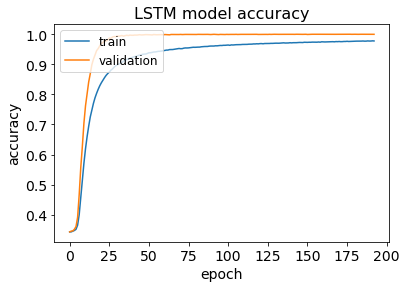

In [ ]:
# summarize history for accuracy
plt.plot(lstm_history['accuracy'])
plt.plot(lstm_history['val_accuracy'])
plt.title('LSTM model accuracy', fontsize=16)
plt.ylabel('accuracy', fontsize=14)
plt.xlabel('epoch', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(['train', 'validation'], loc='upper left', fontsize=12)
plt.show()

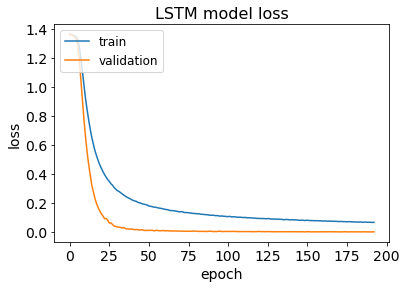

In [ ]:
# summarize history for loss
plt.plot(lstm_history['loss'])
plt.plot(lstm_history['val_loss'])
plt.title('LSTM model loss', fontsize=16)
plt.ylabel('loss', fontsize=14)
plt.xlabel('epoch', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(['train', 'validation'], loc='upper left', fontsize=12)
plt.show()

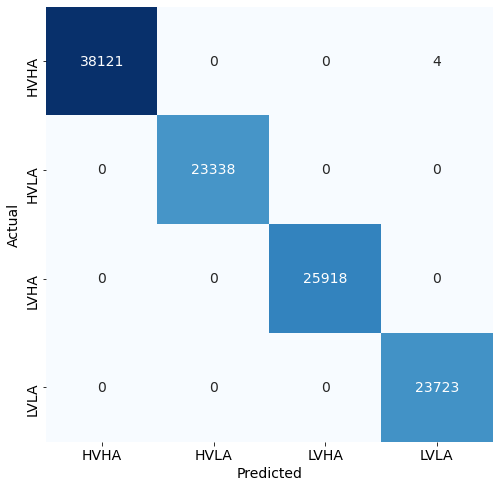

Classification Report:
----------------------
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     38125
           1       1.00      1.00      1.00     23338
           2       1.00      1.00      1.00     25918
           3       1.00      1.00      1.00     23723

    accuracy                           1.00    111104
   macro avg       1.00      1.00      1.00    111104
weighted avg       1.00      1.00      1.00    111104



In [ ]:
class_names = ['HVHA', 'HVLA', 'LVHA', 'LVLA']

y_pred = lstm_model.predict(x_test)

y_predict = []

for i in range(len(y_pred)):
    y_predict.append(np.argmax(y_pred[i]))

y_predict = np.array(y_predict)
yt_test = np.argmax(y_test, axis=1)

cm = confusion_matrix(yt_test, y_predict)
clr = classification_report(yt_test, y_predict)

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False, cmap='Blues', annot_kws={"size":14})
plt.xticks(np.arange(4) + 0.5, class_names, fontsize=14)
plt.yticks(np.arange(4) + 0.5, class_names, fontsize=14)
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("Actual", fontsize=14)
# plt.title("Confusion Matrix for LSTM Model")
plt.show()

print("Classification Report:\n----------------------\n", clr)